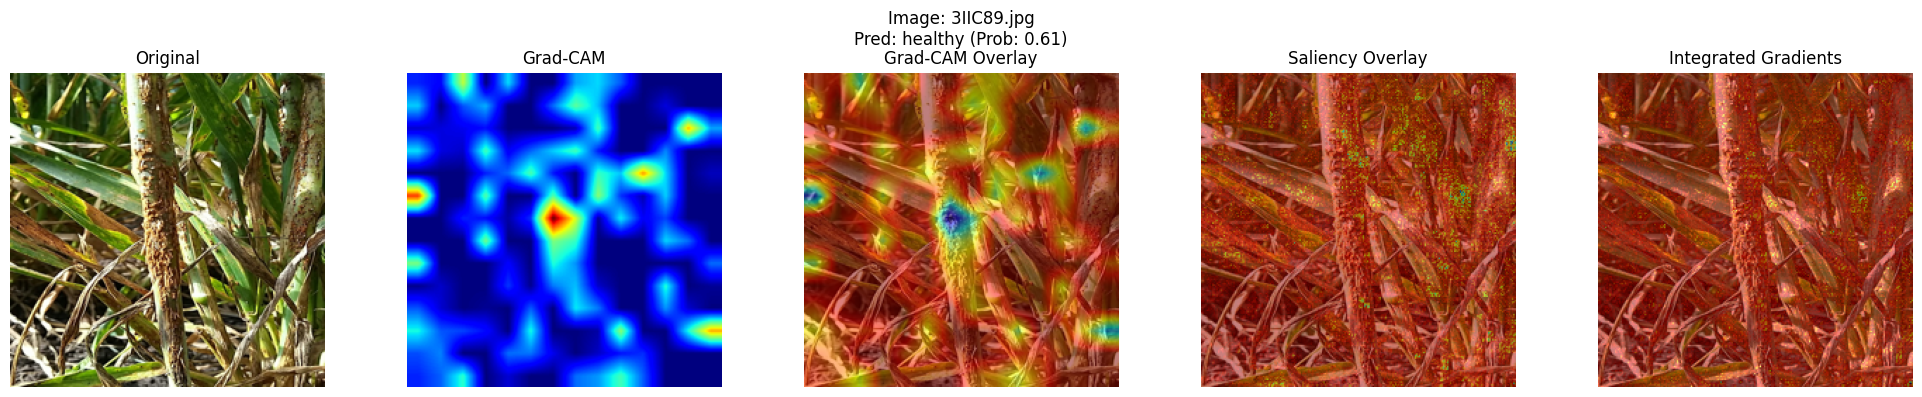

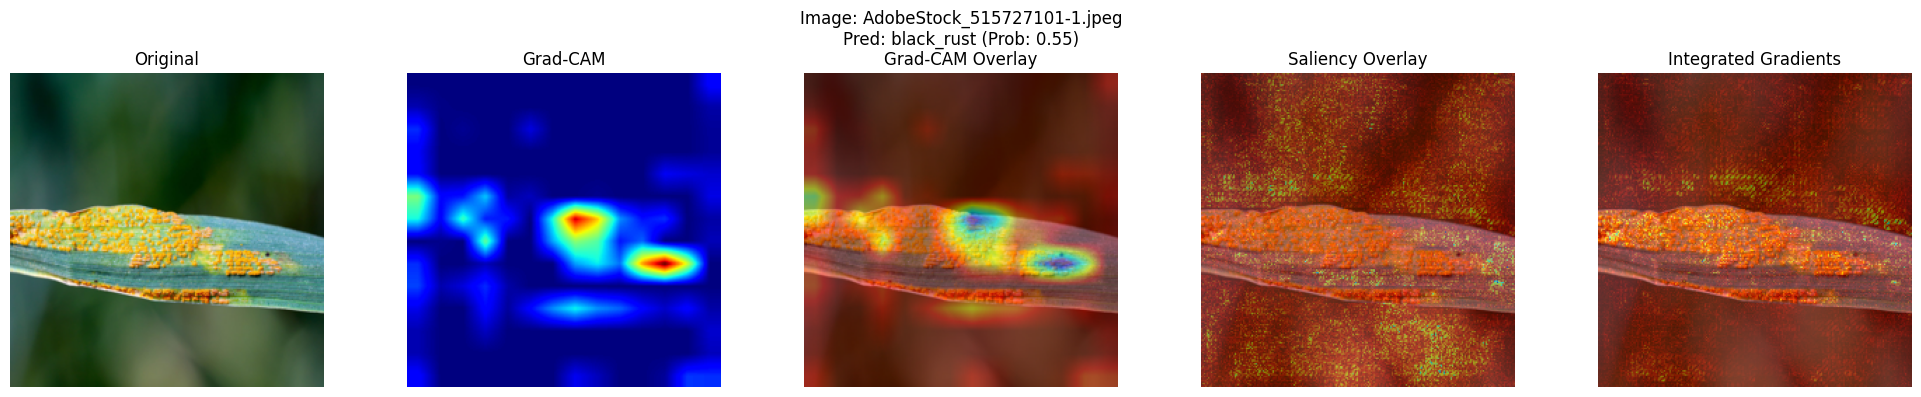

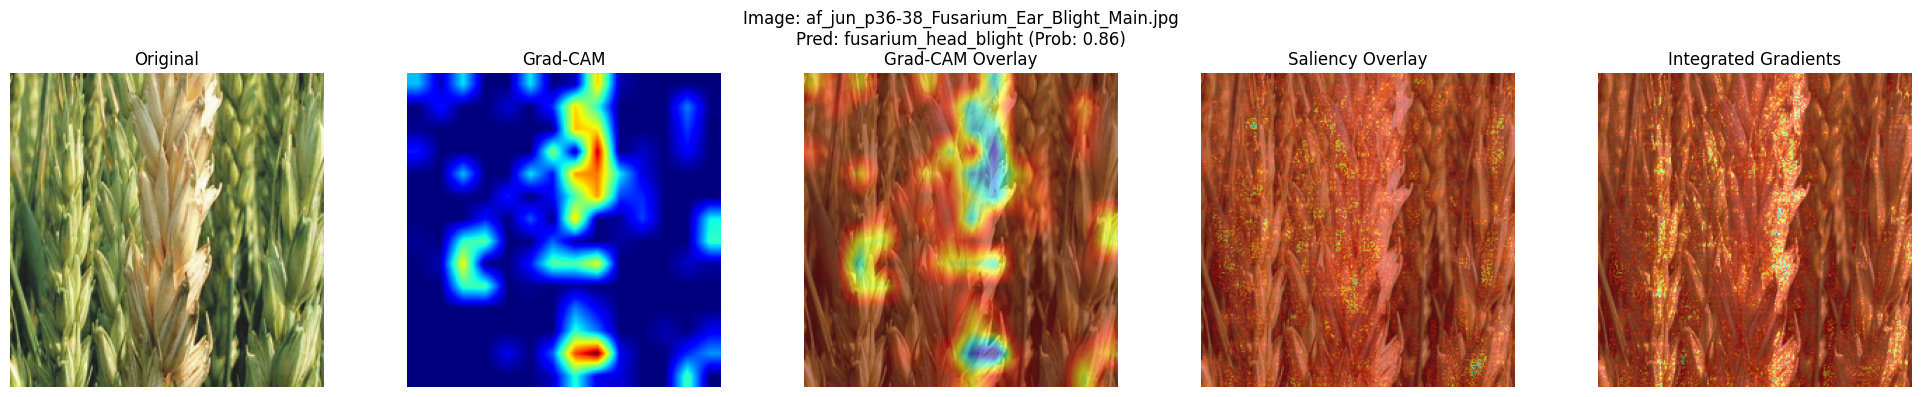

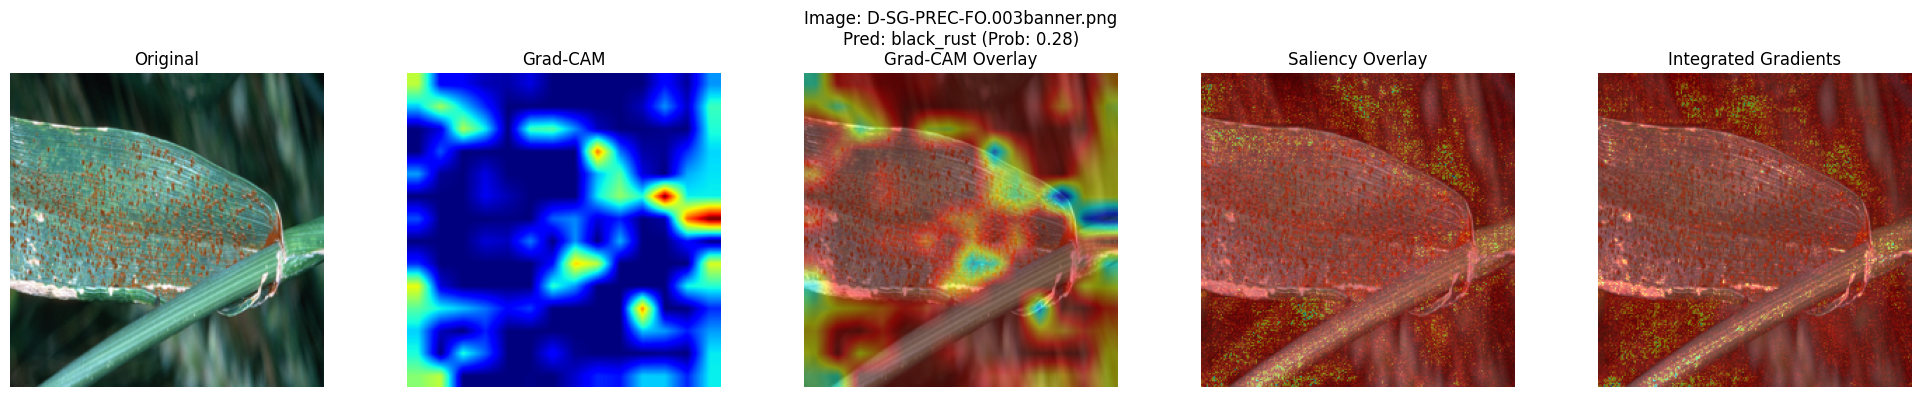

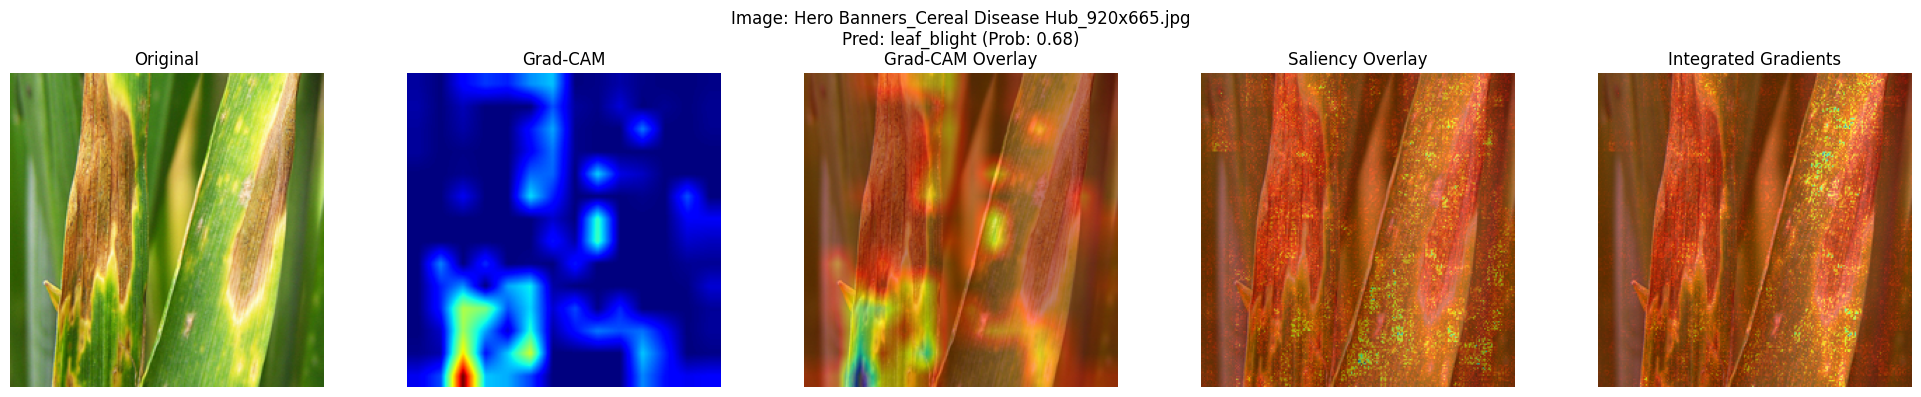

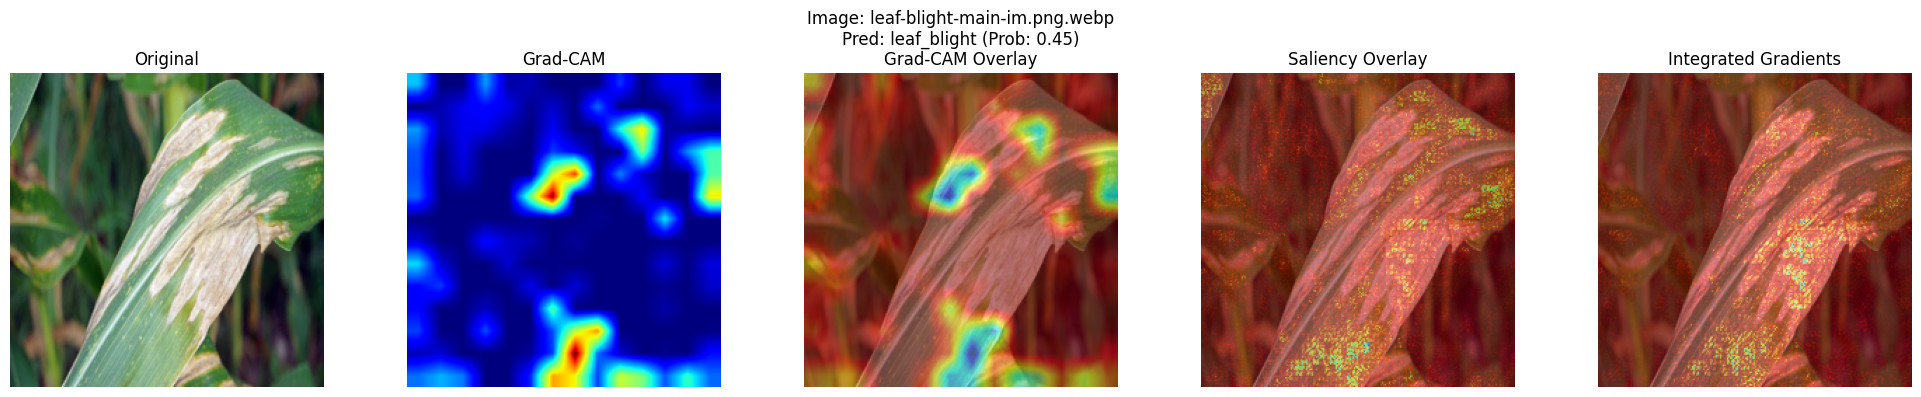

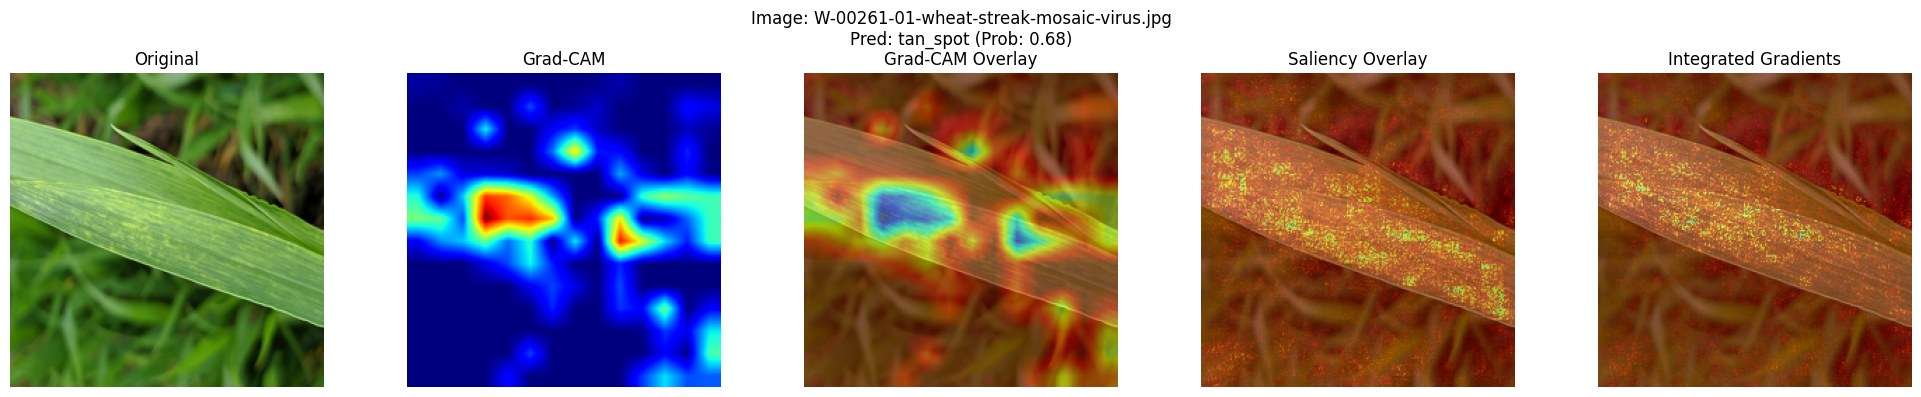

In [4]:


import os
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sc_convnext_model import SCConvNeXt

# Paths
MODEL_PATH = 'saved_models_and_data/wheat_disease_sc_convnext_model.pth'
TEST_IMAGES_DIR = 'test_images'
IMAGE_SIZE = (224, 224)

# Class labels (update if needed)
def get_class_labels(dataset_dir):
    return sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])

DATASET_DIR = 'dataset'
class_labels = get_class_labels(DATASET_DIR)

# Preprocessing
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SCConvNeXt(num_classes=len(class_labels))
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

# Grad-CAM implementation for SCConvNeXt
def get_last_conv_layer(model):
    # For ConvNeXt-T, the last conv block is model.backbone.features[4]
    return model.backbone.features[4]

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))
    def __call__(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        loss = output[0, class_idx]
        loss.backward()
        if self.gradients is None or self.activations is None:
            raise RuntimeError("GradCAM hooks did not capture gradients or activations. Check target_layer.")
        gradients = self.gradients[0]
        activations = self.activations[0]
        weights = gradients.mean(dim=(1, 2))
        cam = (weights[:, None, None] * activations).sum(dim=0)
        cam = torch.relu(cam)
        cam = cam.cpu().numpy()
        cam = cv2.resize(cam, IMAGE_SIZE)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam
    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

# Saliency Map implementation
def compute_saliency_map(model, input_tensor, class_idx=None):
    input_tensor = input_tensor.clone().detach().requires_grad_(True)
    model.zero_grad()
    output = model(input_tensor)
    if class_idx is None:
        class_idx = output.argmax(dim=1).item()
    loss = output[0, class_idx]
    loss.backward()
    saliency = input_tensor.grad.data.abs().squeeze().cpu().numpy()
    saliency = np.max(saliency, axis=0)
    saliency = cv2.resize(saliency, IMAGE_SIZE)
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
    return saliency

# Integrated Gradients implementation
def compute_integrated_gradients(model, input_tensor, class_idx=None, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(input_tensor)
    scaled_inputs = [baseline + (float(i) / steps) * (input_tensor - baseline) for i in range(0, steps + 1)]
    grads = []
    for scaled in scaled_inputs:
        scaled.requires_grad_()
        output = model(scaled)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        loss = output[0, class_idx]
        model.zero_grad()
        loss.backward()
        grads.append(scaled.grad.data.clone() if scaled.grad is not None else torch.zeros_like(scaled))
    avg_grads = torch.mean(torch.stack(grads), dim=0)
    integrated_grads = (input_tensor - baseline) * avg_grads
    integrated_grads = integrated_grads.abs().squeeze().cpu().numpy()
    integrated_grads = np.max(integrated_grads, axis=0)
    integrated_grads = cv2.resize(integrated_grads, IMAGE_SIZE)
    integrated_grads = (integrated_grads - integrated_grads.min()) / (integrated_grads.max() - integrated_grads.min() + 1e-8)
    return integrated_grads

# Helper to overlay heatmap
def show_cam_on_image(img: np.ndarray, mask: np.ndarray, alpha=0.5):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

# Main loop for prediction and visualization
target_layer = get_last_conv_layer(model)
gradcam = GradCAM(model, target_layer)

for img_name in os.listdir(TEST_IMAGES_DIR):
    img_path = os.path.join(TEST_IMAGES_DIR, img_name)
    img_pil = Image.open(img_path).convert('RGB')
    img_tensor = transform(img_pil).unsqueeze(0).to(device)
    # Prediction
    with torch.no_grad():
        output = model(img_tensor)
        pred_idx = output.argmax(dim=1).item()
        pred_label = class_labels[pred_idx]
        prob = torch.softmax(output, dim=1)[0, pred_idx].item()
    # Grad-CAM
    cam = gradcam(img_tensor, class_idx=pred_idx)
    # Saliency Map
    saliency = compute_saliency_map(model, img_tensor, class_idx=pred_idx)
    # Integrated Gradients
    ig = compute_integrated_gradients(model, img_tensor, class_idx=pred_idx)
    # Prepare image for overlay
    img_np = np.array(img_pil.resize(IMAGE_SIZE)).astype(np.float32) / 255.0
    cam_img = show_cam_on_image(img_np, cam)
    sal_img = show_cam_on_image(img_np, saliency)
    ig_img = show_cam_on_image(img_np, ig)
    # Plot
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 5, 1)
    plt.imshow(img_pil.resize(IMAGE_SIZE))
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1, 5, 2)
    plt.imshow(cam, cmap='jet')
    plt.title('Grad-CAM')
    plt.axis('off')
    plt.subplot(1, 5, 3)
    plt.imshow(cam_img)
    plt.title('Grad-CAM Overlay')
    plt.axis('off')
    plt.subplot(1, 5, 4)
    plt.imshow(sal_img)
    plt.title('Saliency Overlay')
    plt.axis('off')
    plt.subplot(1, 5, 5)
    plt.imshow(ig_img)
    plt.title('Integrated Gradients')
    plt.axis('off')
    plt.suptitle(f'Image: {img_name}\nPred: {pred_label} (Prob: {prob:.2f})')
    plt.tight_layout()
    plt.show()

gradcam.remove_hooks() 